In [1]:
from typing import List
import pandas as pd
import chess
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
moves = pd.read_parquet("../data/chess_game_0001_100K.parquet")["Moves"].values
moves = list(map(lambda x: x.tolist(), moves))

In [3]:
def get_moved_piece(moves: List[str]) -> List[str]:
    board = chess.Board()
    board.reset()
    moved_pieces = []
    for move in moves:
        move = chess.Move.from_uci(move)
        board.push(move)
        moved_piece = board.piece_at(move.to_square)
        moved_pieces.append(str(moved_piece))   
    return moved_pieces


pieces = []
for m in tqdm(moves):
    pieces.append(get_moved_piece(m))

100%|██████████| 100000/100000 [01:40<00:00, 990.15it/s]


In [5]:
games = []

for m, p in zip(moves, pieces):
    game = []
    for idx in range(len(m)):
        game.append(p[idx].lower() + m[idx])
    games.append(game)
games

[['pd2d4',
  'pf7f5',
  'pg2g3',
  'pg7g6',
  'bf1g2',
  'bf8g7',
  'ng1f3',
  'pd7d6',
  'pc2c3',
  'pe7e6',
  'pa2a4',
  'ng8f6',
  'qd1c2',
  'qd8e7',
  'nb1d2',
  'pe6e5',
  'pd4e5',
  'pd6e5',
  'pe2e4',
  'nb8c6',
  'ke1g1',
  'pf5e4',
  'nd2e4',
  'bc8f5',
  'nf3d2',
  'ke8c8',
  'pb2b4',
  'bg7h6',
  'rf1e1',
  'bh6d2',
  'bc1d2',
  'nf6e4',
  'bg2e4',
  'qe7e6',
  'bd2g5',
  'rd8d6',
  'ra1d1',
  'rd6d1',
  're1d1',
  'ph7h6',
  'bg5e3',
  'pa7a5',
  'qc2b1',
  'ph6h5',
  'pb4b5',
  'nc6e7',
  'be3g5',
  'rh8e8',
  'ph2h4',
  'qe6c4',
  'rd1e1',
  'bf5e4',
  're1e4',
  'qc4e6',
  'bg5f4',
  'qe6f5',
  'bf4e5',
  'ne7d5',
  'qb1e1',
  'nd5b6',
  'pf2f4',
  'nb6d7',
  'qe1e2',
  'pb7b6',
  're4e3',
  're8e7',
  're3e4',
  'nd7c5',
  're4d4',
  're7d7',
  'kg1g2',
  'kc8d8',
  'kg2h2',
  'kd8c8',
  'qe2g2',
  'kc8b8',
  'qg2a2',
  'kb8a7',
  'qa2g2',
  'ka7b8',
  'qg2e2',
  'kb8c8',
  'qe2f3',
  'kc8b8',
  'qf3d1',
  'kb8c8',
  'qd1e2',
  'kc8b8',
  'qe2d1',
  'kb8b7',
  'rd4d7',

In [6]:
from collections import defaultdict
import numpy as np
import pandas as pd


def get_cooccurrence_matrix(moves: List[List[str]], offset: int) -> pd.DataFrame:
    """
    Create a co-occurrence matrix for the given moves with a specified offset.
    
    Args:
        moves (List[List[str]]): List of games, each containing a list of moves.
        offset (int): The offset to consider for co-occurrence.
    
    Returns:
        pd.DataFrame: Co-occurrence matrix.
    """
    co_occurrence = defaultdict(lambda: defaultdict(int))
    
    for game in tqdm(moves):
        for idx, move in enumerate(game):
            neighbor_idx = idx + offset
            if neighbor_idx >= (len(game) - 1):
                break
            neighbor_move = game[neighbor_idx]
            co_occurrence[move][neighbor_move] += 1

    unique_moves = list(sorted(set(m for game in moves for m in game)))
    move_idx_map = {k: v for v, k in enumerate(unique_moves)}
    matrix = np.zeros((len(unique_moves), len(unique_moves)))

    for move, value in tqdm(co_occurrence.items()):
        move_idx = move_idx_map[move]
        for neighbor_move, count in value.items():
            neighbor_move_idx = move_idx_map[neighbor_move]
            matrix[move_idx, neighbor_move_idx] = count
    count_df = pd.DataFrame(matrix, columns=unique_moves, index=unique_moves)
    return count_df
# Example input
offset = 2
count_df = get_cooccurrence_matrix(games, offset)
matrix = count_df.values

100%|██████████| 4075/4075 [00:01<00:00, 3545.46it/s]


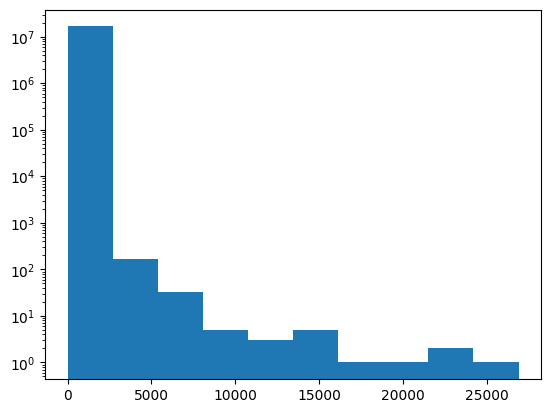

In [7]:
plt.hist(matrix.flatten())
plt.yscale("log")

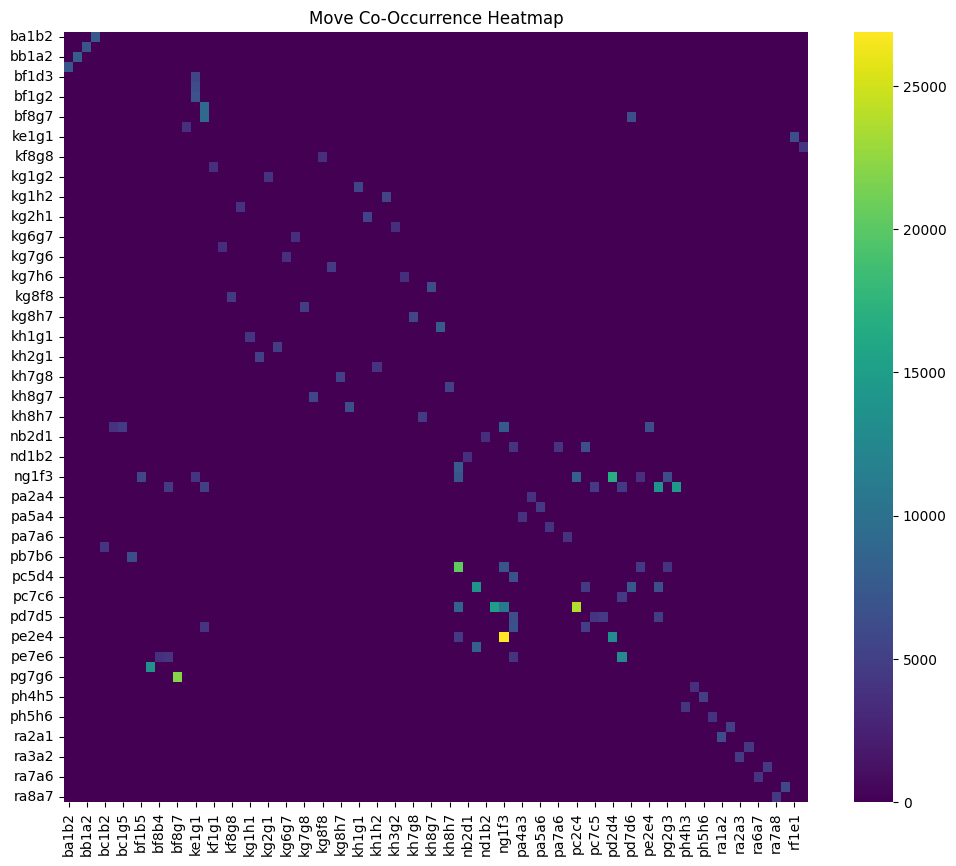

In [8]:
def prune_count_df(count_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """
    Prune the count DataFrame by removing rows and columns with counts below a certain threshold.
    
    Args:
        count_df (pd.DataFrame): The count DataFrame to prune.
        threshold (int): The threshold for pruning.
    
    Returns:
        pd.DataFrame: The pruned count DataFrame.
    """
    pruned_df = count_df.copy()
    pruned_df[pruned_df <= threshold] = 0
    pruned_df = pruned_df.drop(pruned_df[pruned_df.sum(axis=1) == 0].index)
    drop_cols = pruned_df.columns[pruned_df.sum(axis=0) == 0]
    pruned_df = pruned_df.drop(columns=drop_cols)
    return pruned_df

mini_df = prune_count_df(count_df, 3500)
# prune rows and columns under a certain count
plt.figure(figsize=(12, 10))
sns.heatmap(mini_df, cmap="viridis")
plt.title("Move Co-Occurrence Heatmap")
plt.show()

<Figure size 1500x800 with 0 Axes>

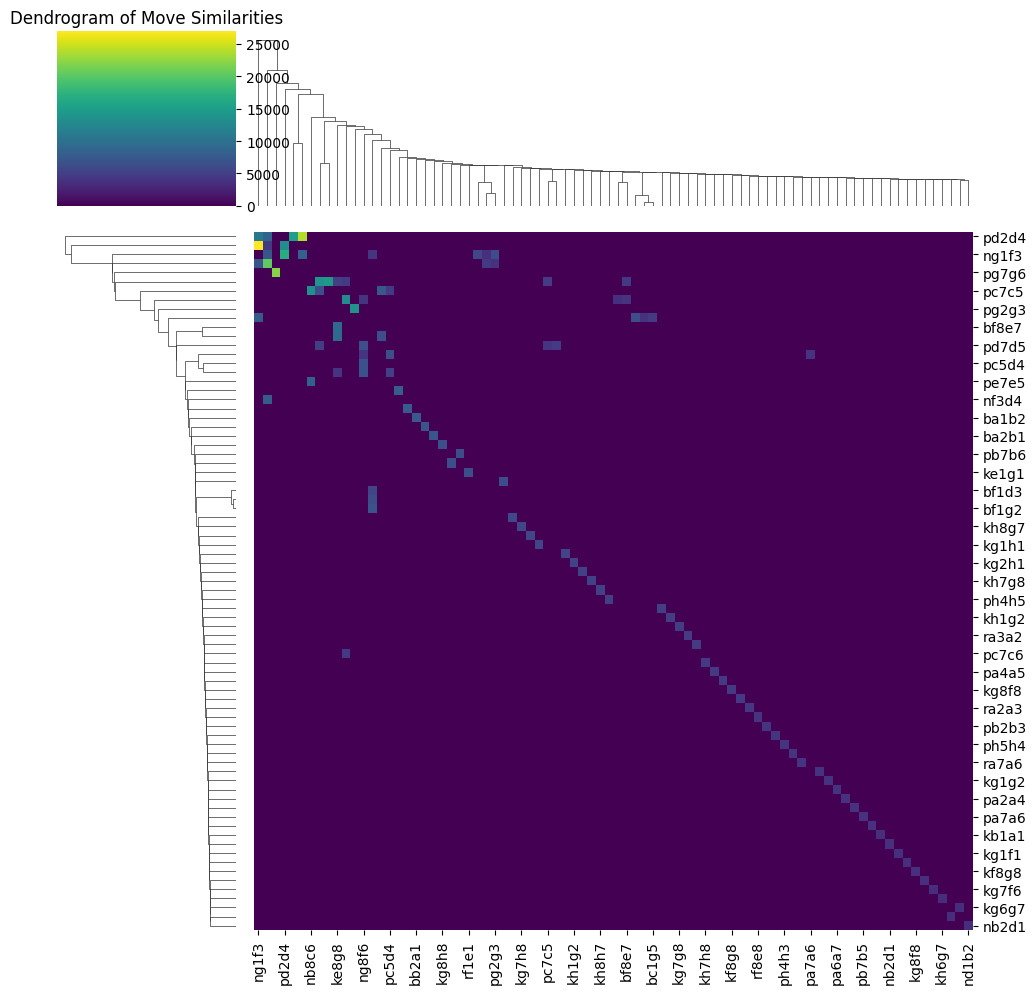

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Use linkage on the condensed distance matrix
linkage_matrix = linkage(mini_df, method='ward')

plt.figure(figsize=(15, 8))
sns.clustermap(mini_df, cmap="viridis")
plt.title("Dendrogram of Move Similarities")
plt.tight_layout()
plt.show()


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 1959/1959 [00:00<00:00, 8049.49it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 9819.20it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 7785.20it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 8473.94it/s]
/home/robin/miniconda3/envs/nlp/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00

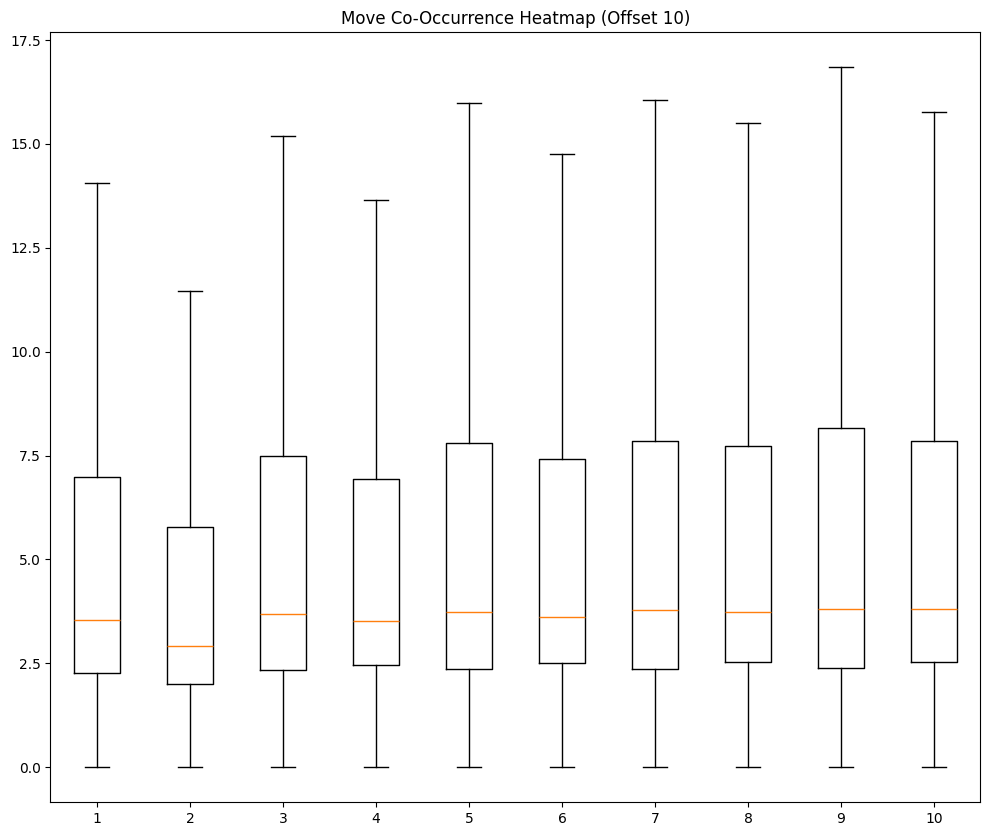

In [10]:
plt.figure(figsize=(12, 10))
bins = np.linspace(0, 40, 101)
for offset in np.arange(1, 11):
    count_df = get_cooccurrence_matrix(moves, offset)
    count_df.sort_index(inplace=True)
    p = count_df / count_df.sum(axis=1)
    entropy = -np.sum(p * np.nan_to_num(np.log(p), copy=True, neginf=0), axis=1)
    plt.boxplot(entropy, positions=[offset], widths=0.5, showfliers=False)
plt.title(f"Move Co-Occurrence Heatmap (Offset {offset})")
plt.show()



In [33]:
data = defaultdict(lambda: defaultdict(int))
for game in tqdm(games):
    for move in game:
        piece = move[0]
        move = move[1:]
        data[piece][move] += 1

df = []
for piece, move_counts in data.items():
    df.append({"piece": piece, **move_counts})
df = pd.DataFrame(df)
df = df.fillna(0)
df.head()

100%|██████████| 100000/100000 [00:08<00:00, 11454.32it/s]


piece     d2d4     f7f5     g2g3     g7g6     d7d6     c2c3     e7e6  \
0     p  85841.0  31479.0  50631.0  61414.0  44051.0  29182.0  58331.0   
1     b      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2     n      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3     q   3225.0    938.0    715.0    827.0   2664.0   3842.0   3648.0   
4     k      0.0      0.0  20680.0  21409.0  11086.0   9775.0  14897.0   

      a2a4     e6e5  ...  e2f1r  c7b8r  b7a8r  f7e8r  b2c1r  f2e1r  g2h1r  \
0  40970.0  25696.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      0.0      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      0.0      0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3    514.0   2077.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4      0.0  13309.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   f7g8r  b2a1r  g7h8r  
0    0.0    0.0    0.0  
1    0.0    0.0    0.0  
2    0.0    0.0    0.0  
3    0.0    0.0    0.0  
4    0.0    0.0    0.0  

[5 rows x 1960 columns]

In [34]:
df = df.set_index("piece")

/tmp/ipykernel_175683/2668028607.py:2: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(p * np.nan_to_num(np.log2(p), neginf=0), axis=0)


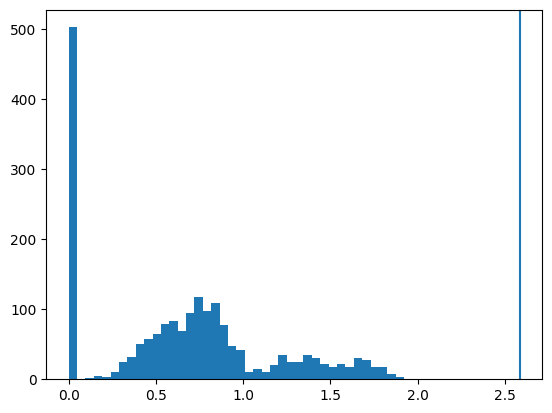

In [40]:
p = df.values / df.values.sum(axis=0)
entropy = -np.sum(p * np.nan_to_num(np.log2(p), neginf=0), axis=0)
plt.hist(entropy, bins=40)
plt.axvline(np.log2(len(df.index)))

In [ ]:
p = df.values / df.values.sum(axis=0)
entropy = -np.sum(p * np.nan_to_num(np.log2(p), neginf=0), axis=0)
plt.hist(entropy, bins=40)
plt.axvline(np.log2(len(df.index)))

In [4]:
import sys
sys.path.append("..")
from nlpChess.models.lit_modules import SeqAnnotator
model = SeqAnnotator.load_from_checkpoint("../checkpoints/pieces/lstm-best.ckpt", label="pieces", word2vec="../model_weights/word2vec.model")

In [5]:
from datasets import load_dataset
from nlpChess.dataset.ChessDataset import ChessDataset
ds = load_dataset("PaoloGinefra03/ChessGamesForNlp", split="test")
ds = ChessDataset(dataset=ds, inputColumns=["Moves"], labelColumns=["pieces"])

Using the latest cached version of the dataset since PaoloGinefra03/ChessGamesForNlp couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/robin/.cache/huggingface/datasets/PaoloGinefra03___chess_games_for_nlp/default/0.0.0/108db0be44291181a77849fd5670019c46b3afac (last modified on Sat May 24 17:12:09 2025).


Loading dataset with columns  ['Moves', 'pieces']
Loaded 10001 rows and 2 columns


Converting columns to indices: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]


In [6]:
ds.getLabelLookupTables()

{'pieces': {'p': 1, 'n': 2, 'q': 3, 'b': 4, 'k': 5, 'r': 6}}

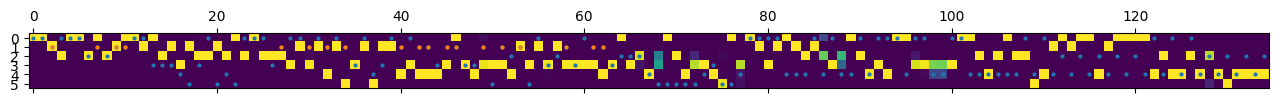

In [7]:
import torch
idx = 0
with torch.no_grad():
    x, y = ds[idx]
    out, hidden = model.forward(x[0])
plt.matshow(out.T)
plt.scatter(torch.arange(len(out)), y[0] -1, s=4)
plt.scatter(torch.arange(len(out))[y[0] == 2], y[0][y[0] == 2] -1, s=4)

In [8]:
preds = []
labels = []
for x, y in tqdm(ds):
    with torch.no_grad():
        preds.append(model.forward(x[0])) 
        labels.append(y)

100%|██████████| 10001/10001 [02:45<00:00, 60.33it/s]


In [9]:
import numpy as np

cross_entropies = []
for (pred, _), (label,) in zip(preds, labels):
    cross_entropies.append(-np.nan_to_num(torch.log(pred), neginf=0)[torch.arange(len(pred)), label - 1])

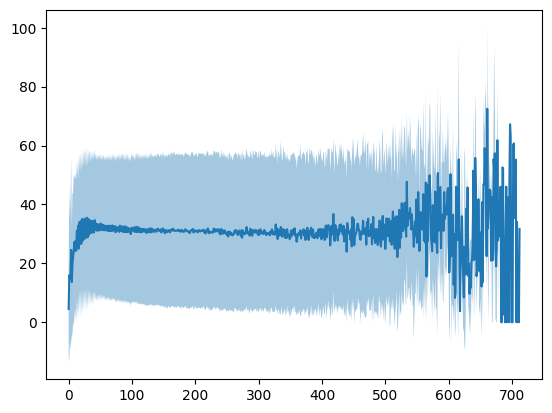

In [19]:
max_len = max(list(map(lambda x: len(x[0]), preds)))

res = []
for ce in cross_entropies:
    if (max_len - len(ce)) > 0:
        res.append(np.concatenate([ce, -np.ones(max_len - len(ce))]))
    else:
        res.append(ce)
res = np.stack(res)
mean = np.mean(res, axis=0, where=res > -1)
std =  np.std(res, axis=0, where=res > -1)
plt.fill_between(np.arange(res.shape[1]), mean-std, mean + std, alpha=0.4)
plt.plot(mean)